# Evolutionary Strategies
Evolutionary strategies are a class of evolutionary algorithms first developed in the 1960s. These algorithms are notable for their statistical recombination of the population to inform the next generation and are most often used for continuous optimization problem. Evolutionary Strategies such as CMA-ES, which we'll discuss next, have a long history of application in a variety of domains and recently have been applied to the optimization of neural network weights.

1. I. Rechenberg and M. Eigen. Evolutionsstrategie: Optimierung Technischer Systeme nach Prinzipien der Biologischen Evolution. Frommann-Holzboog Stuttgart, 1973.

2. Wierstra, Daan, et al. "Natural evolution strategies." The Journal of Machine Learning Research 15.1 (2014): 949-980. PDF

3. Salimans, Tim, et al. "Evolution strategies as a scalable alternative to reinforcement learning." arXiv preprint arXiv:1703.03864 (2017).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
from IPython import display

Let's start by optimizing over a objective functions with an offset center.

In [2]:
def wave(x):
    x = np.array(x)
    return len(x) * sum(np.sin(x)) + 3.5

def rastrigin(x):
    x = np.array(x)
    return 10 * len(x) - sum(x**2)

def rastrigin_complex(x):
    x = np.array(x)
    return 10 * len(x) - sum(x**2 - 10 * np.cos(2 * np.pi * x))

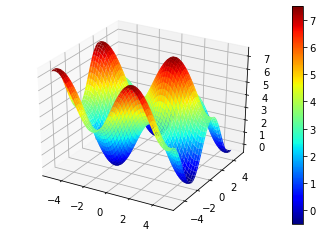

In [3]:
xs = np.linspace(-5, 5, 100)
ys = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xs,ys)
objective = rastrigin
fz = wave(np.array([X, Y]))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fz, cmap=cm.jet)
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(fz)
fig.colorbar(m)

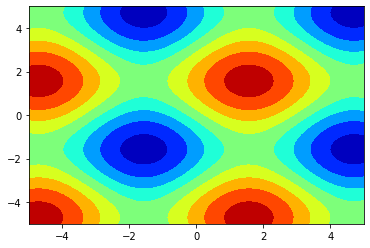

In [4]:
plt.contourf(X,Y,fz,cmap=cm.jet)

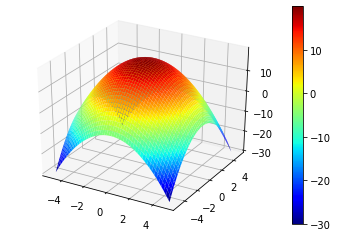

In [5]:
xs = np.linspace(-5, 5, 100)
ys = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xs,ys)
objective = rastrigin
fz = rastrigin(np.array([X, Y]))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fz, cmap=cm.jet)
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(fz)
fig.colorbar(m)

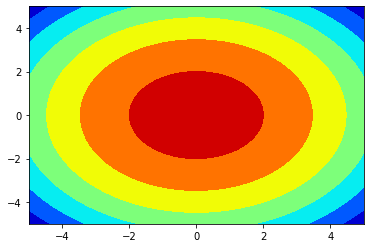

In [6]:
plt.contourf(X,Y,fz,cmap=cm.jet)

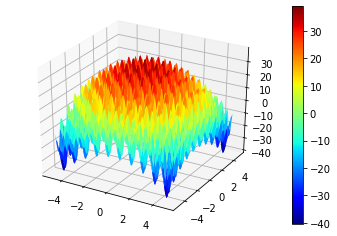

In [7]:
xs = np.linspace(-5, 5, 100)
ys = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(xs,ys)
objective = rastrigin_complex
fz = objective(np.array([X, Y]))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fz, cmap=cm.jet)
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(fz)
fig.colorbar(m)

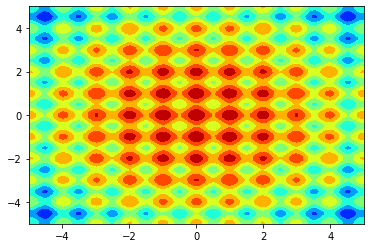

In [8]:
plt.contourf(X,Y,fz,cmap=cm.jet)

We'll start with a very simple example of an evolutionary strategy. In this $(1,\lambda)$ Evolutionary Strategy, we will first create random individuals around an expert with a standard deviation of $\sigma$. This is our population. Let's define some parameters

Notation: $(\mu/\rho,\lambda)$ or $(\mu/\rho+\lambda)$
In this notation, $\mu$ is the number of parents, $\rho$ is the number of parents involved in creating the offspring, and $\lambda$ is the number of offspring. $(\mu/\rho+\lambda)$ means the parents are included for creating the next population, $(\mu/\rho,\lambda)$ means the parents are not included. We've already seen the $(1+1)$ and $(1+\lambda)$ algorithms, where the 1 parent is included in the next population based on its fitness. CMA-ES is a $(\mu/\mu_I,\lambda)$ algorithm where a transformation of $\mu$, $\mu_I$, will inform the next population.

In [9]:
npop = 50     # population size
sigma = 0.1   # noise standard deviation
alpha = 0.001 # step size
d = 2       # dimension
x = np.random.randn(d).tolist()  # initial expert with d dimension

Since we'll be staying in the continuous optimization domain today, we won't define an Individual class but will use matrices for our population. Let's now create the population around the expert x with standard deviation $\sigma$. We will use a Normal distribution.

Population is kept in matrices.

In [10]:
N = np.random.randn(npop, d) # d=2 here is the dimensions
P = x + sigma * N            # population is created near the expert x

Now we have our population and can evaluate them. We will also normalize the evaluation $f(x)$ using $\frac{f(x) - \mu(f(x))}{\sigma(f(x))}$

In [11]:
R = np.zeros(npop) # fitness values
for i in range(len(R)):
    R[i] = objective(P[i, :])
    
A = (R - np.mean(R)) / np.std(R) # normalized fitness values

In [12]:
xs = np.linspace(np.min(P[:,0]), np.max(P[:,0]), 100)
ys = np.linspace(np.min(P[:,1]), np.max(P[:,1]), 100)
X, Y = np.meshgrid(xs,ys)
fz = rastrigin(np.array([X, Y]))

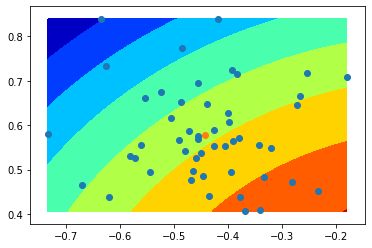

In [13]:
plt.contourf(X,Y,fz,cmap=cm.jet)
plt.scatter(P[:, 0], P[:, 1], label="pop", cmap=cm.jet)
plt.scatter(x[0], x[1], label="expert")


As we can see, some individuals in our distribution are better than our current expert. We'll shift towards those individuals by multiplying each individual in $N$ by their normalized fitness $A$, then summing over all individuals. This gives us the direction of the gradient based on our population.

In [14]:
A = A.reshape(A.shape[0], 1)
gradient = np.sum(N*A, axis=0)/npop
print(f"expert : {x}")
print(f"gradient : {gradient}")

expert : [-0.4427506938823118, 0.578332383171287]
gradient : [0.37254951 0.67469974]


In [15]:
print(f"Previous expert x: {x}")
x = x + (alpha / (npop * sigma)) * gradient
print(f"Updated expert x: {x}")

Previous expert x: [-0.4427506938823118, 0.578332383171287]
Updated expert x: [-0.44267618  0.57846732]


As we can see, we've moved closer to the objective. Let's plot this over multiple steps.

In [16]:
def step_es(x, objective_function, npop=50, sigma=0.1, alpha=0.1, d=2, 
            visualize=True):
    N = np.random.randn(npop, d) # d=2 here is the dimensions
    P = x + sigma * N            # population is created near the expert x
    
    R = np.zeros(npop)           # fitness values
    for i in range(len(R)):
        R[i] = objective_function(P[i, :])

    A = (R - np.mean(R)) / np.std(R) # normalized fitness values
    A = A.reshape(A.shape[0], 1)     # reshape for gradient computation
    
    if visualize:
        plt.scatter(P[:, 0], P[:, 1], label="pop", cmap=cm.jet)
        plt.scatter(x[0], x[1], label="expert")
        
    gradient = np.sum(N*A, axis=0) / npop
    
    return (x + (alpha / (npop * sigma)) * gradient)

In [17]:
def run_es(objective_function, start_point=[-4, 4]):
    npop = 50     # population size
    sigma = 0.1   # noise standard deviation
    alpha = 0.001 # step size
    d = 2         # dimension
    NGEN=500

    xs = np.linspace(-5, 5, 100)
    ys = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(xs,ys)
    fz = objective_function(np.array([X, Y]))

    if start_point:
        # for example expert is starting at this point to visualize
        x = np.array(start_point) 
    else:
        x = np.random.randn(d).tolist()  # initial expert with d dimension

    x_initial = x

    for i in range(NGEN):
        visualize = (i % 10) == 0

        if visualize:
            display.clear_output(wait=True)
            plt.contourf(X,Y,fz,cmap=cm.jet)

        x = step_es(x, objective_function, visualize=visualize)

        if visualize:
            plt.show()

    print(f"Expert started at {x_initial}")
    print(f"Expert ended at {x}")
    print(f"Expert expection at [0, 0]")
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, fz, cmap=cm.jet)
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(fz)
    fig.colorbar(m)

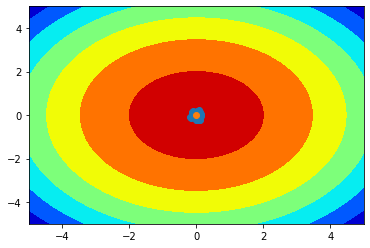

Expert started at [-4  4]
Expert ended at [-0.00261088  0.00445915]
Expert expection at [0, 0]


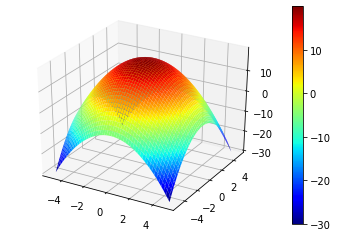

In [18]:
run_es(objective_function=rastrigin)

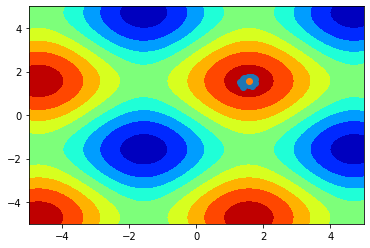

Expert started at [0.9208572917263766, -0.24307449800498906]
Expert ended at [1.58450312 1.5858608 ]
Expert expection at [0, 0]


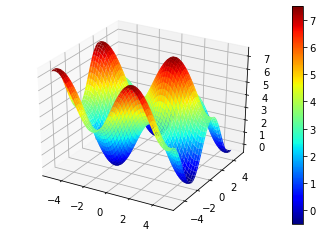

In [19]:
run_es(objective_function=wave, start_point=None)

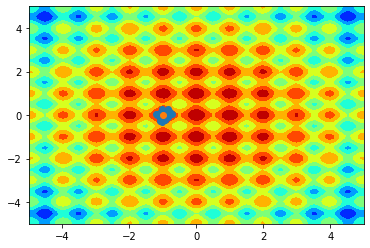

Expert started at [-0.7468631523206999, -0.387157172114903]
Expert ended at [-0.98426897 -0.00899431]
Expert expection at [0, 0]


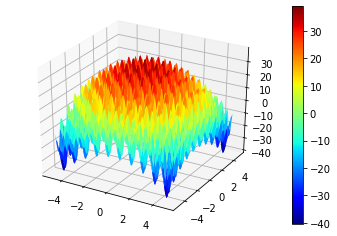

In [20]:
run_es(objective_function=rastrigin_complex, start_point=None)

# Estimation of Distribution Algorithms
EDAs are algorithms that build a probabilistic model of candidate solutions. They worth looking into.

1. Mühlenbein, Heinz, and Gerhard Paass. "From recombination of genes to the estimation of distributions I. Binary parameters." International conference on parallel problem solving from nature. Springer, Berlin, Heidelberg, 1996.
2. Larrañaga, Pedro, and Jose A. Lozano, eds. Estimation of distribution algorithms: A new tool for evolutionary computation. Vol. 2. Springer Science & Business Media, 2001.
3. Pelikan, Martin, David E. Goldberg, and Fernando G. Lobo. "A survey of optimization by building and using probabilistic models." Computational optimization and applications 21.1 (2002): 5-20.

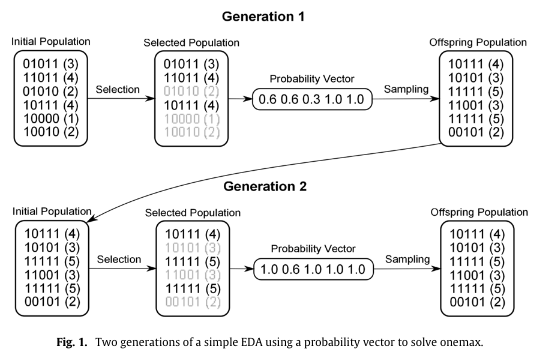

Hauschild, Mark, and Martin Pelikan. "An introduction and survey of estimation of distribution algorithms." Swarm and evolutionary computation 1.3 (2011): 111-128.